<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_ARIMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#ライブラリインストール
install.packages( "tidyverse" )
install.packages( "fable" )
install.packages( "feasts" )
install.packages( "urca" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は人口方程式の考え方に沿って時系列分析します。

>$t$年から$a$年後の人口$(P_{t+a})$は、基準人口$(P_t)$に$t$年から$t+a$年までの  
出生数$(B)$を加え死亡数$(D)$を減じ  
国籍取得数$(IN)$を加え国籍離脱数$(ON)$を減じたものです。  
$P_{t+a}={P_t}+{B_{t\to t+a}}－{D_{t\to t+a}}$
$+{IN_{t\to t+a}}-{ON_{t\to t+a}}$  

# 手順１　データの収集


*  [データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。
*  出生・死亡 [「人口動態調査」（厚生労働省）](https://www.mhlw.go.jp/toukei/list/81-1a.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [13]:
# 該当リポジトリを変数に格納
c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" ) -> repo
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/population_jp_year.csv" )) -> popURL

# ライブラリの読み込み
library( readr )
library( fable )

# ネット上のファイル読み込み
popURL |>
  read_csv( show_col_types = FALSE ) |>
  # ＴＳＩＢＢＬＥライブラリに変換
  as_tsibble( index = Year ) -> pop_tsibble

# 手順２　データの可視化

まず、データをプロットしてみます。

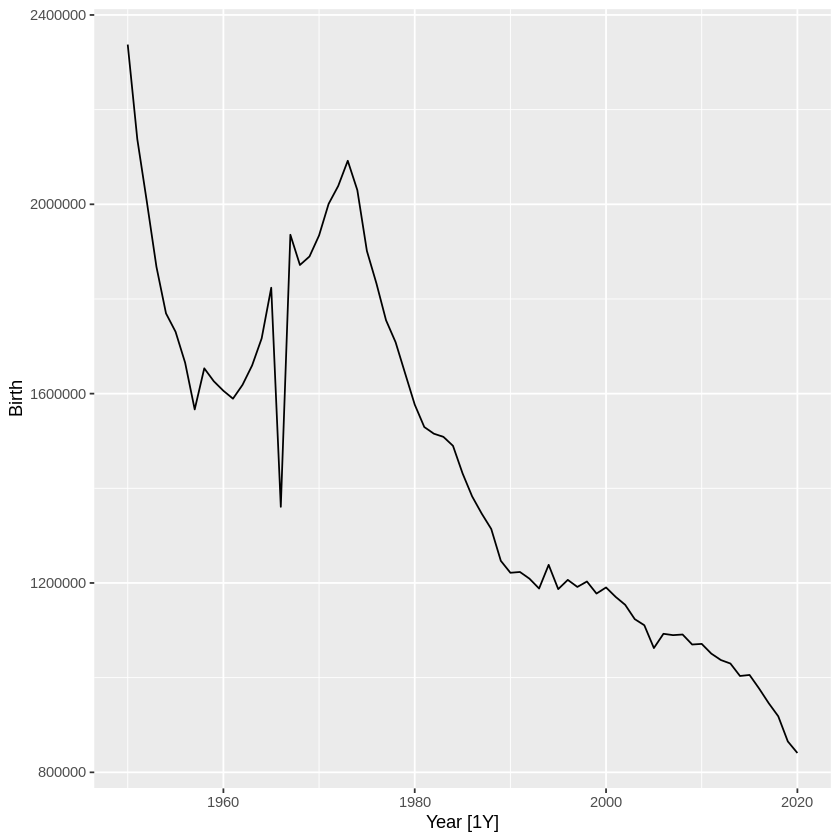

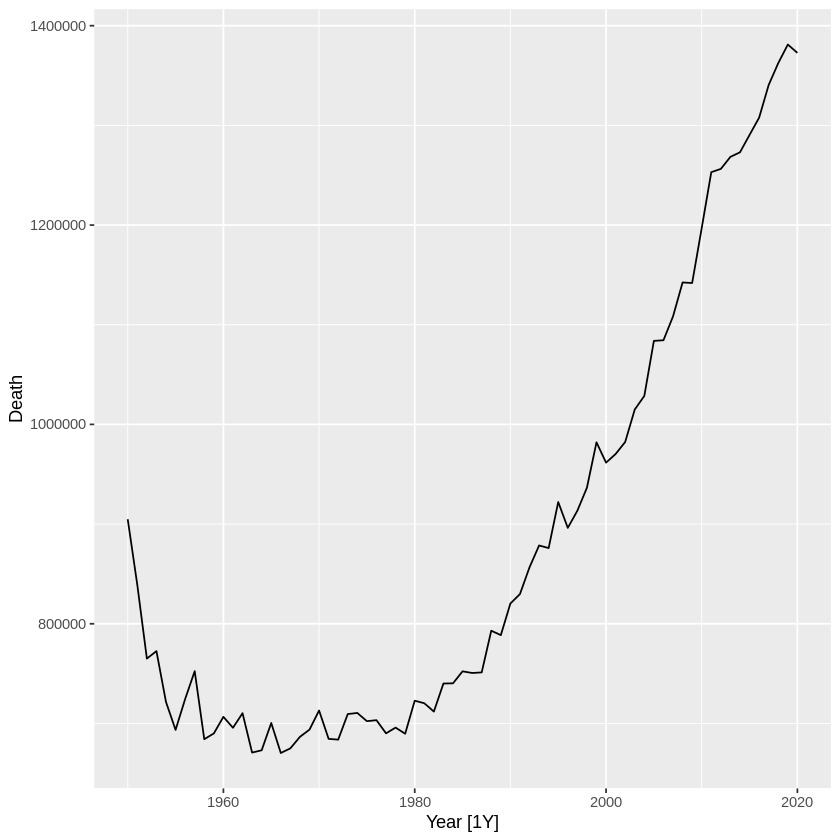

In [14]:
# ライブラリの読み込み
library( ggplot2 )

# 出生数、死亡数のグラフ
pop_tsibble |>
  autoplot( Birth )
pop_tsibble |>
  autoplot( Death )

次に、自己相関を確認してみます。

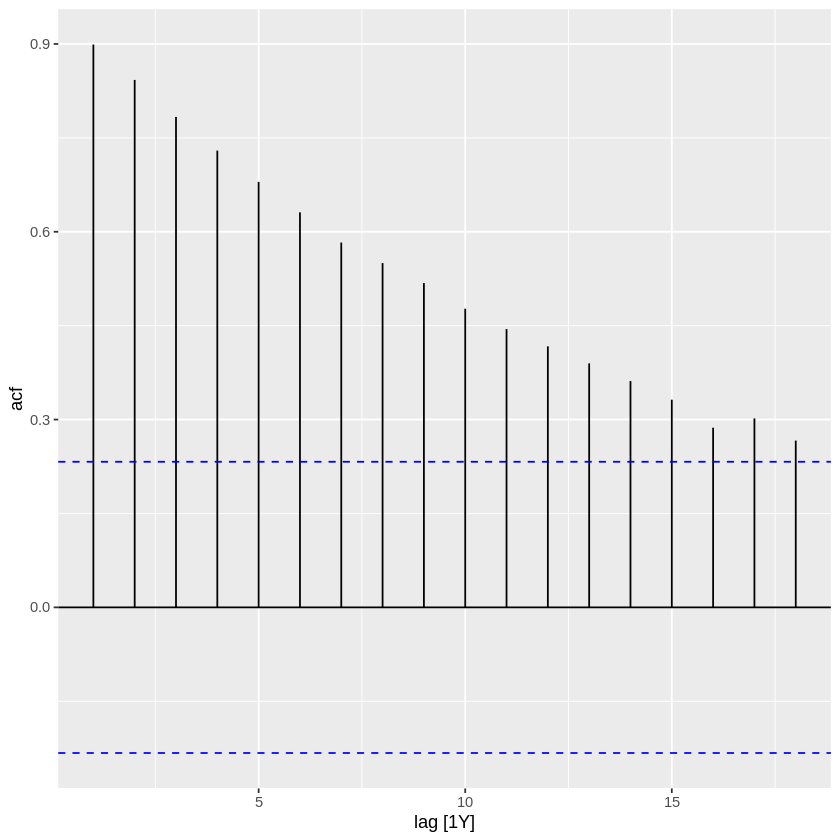

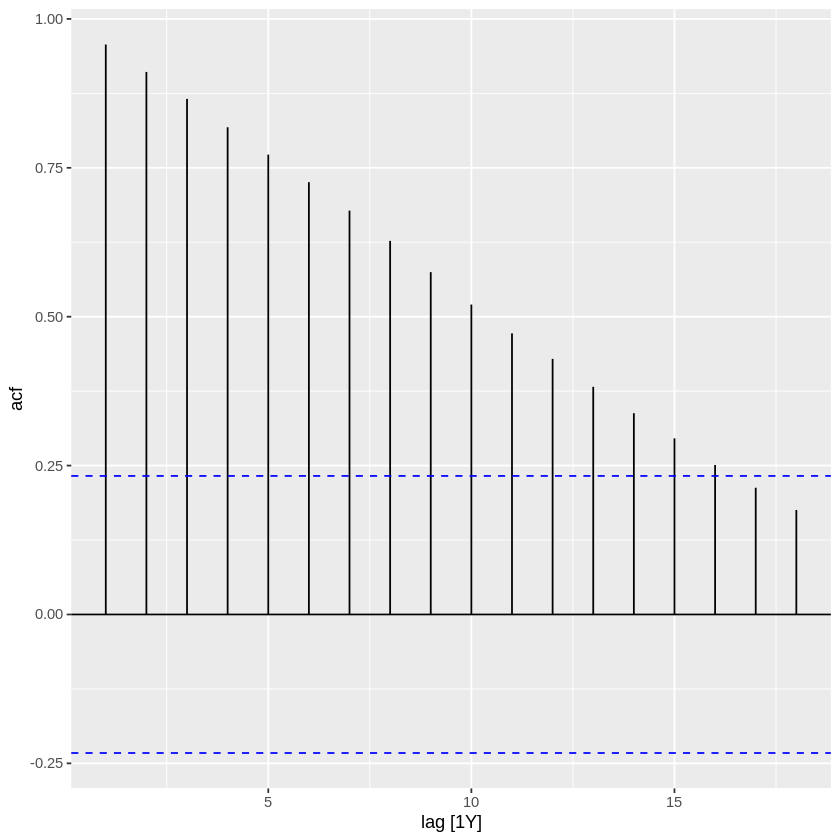

In [15]:
# ライブラリの読み込み
library( feasts )

# 自己相関のグラフ
pop_tsibble |>
  ACF( Birth ) |>
  autoplot()
pop_tsibble |>
  ACF( Death ) |>
  autoplot()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

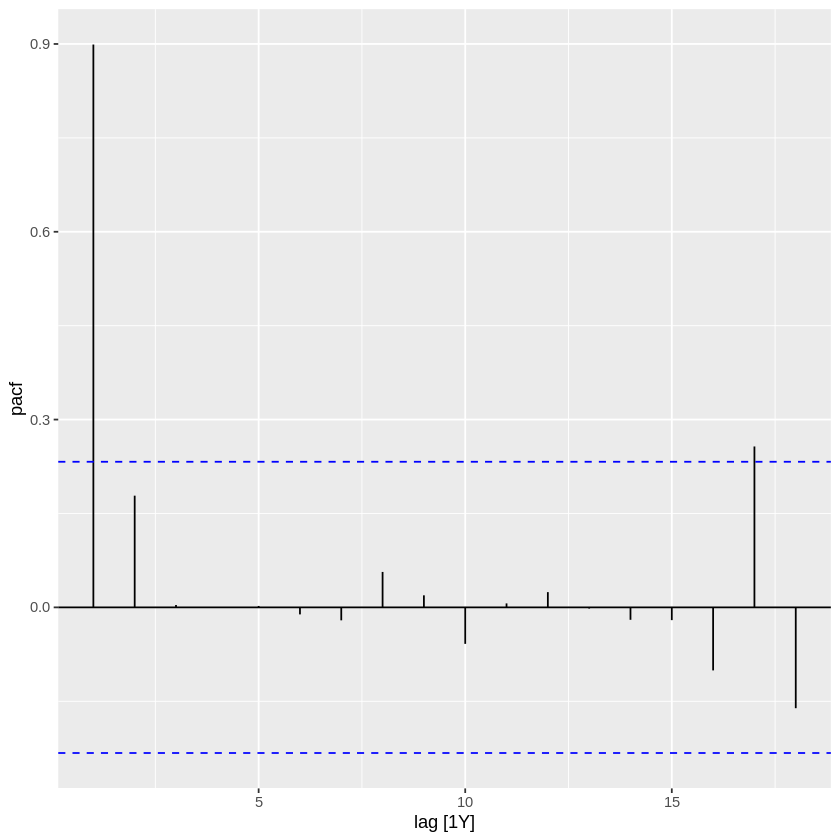

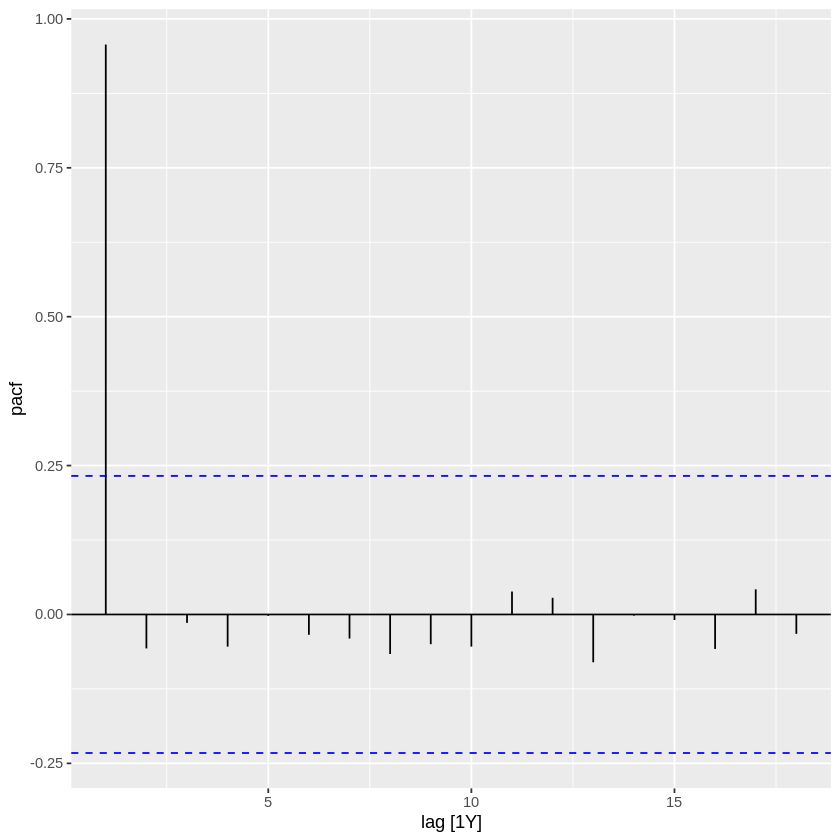

In [16]:
# 偏自己相関のグラフ
pop_tsibble |>
  PACF( Birth ) |>
  autoplot()
pop_tsibble |>
  PACF( Death ) |>
  autoplot()

# 手順３　学習データと予測データの分類

２０１５年までの人口データと２０１４年までの出生、死亡データを学習データとし、  
その後５年間のデータを予測データとします。

In [17]:
# 予測データと訓練データ
6 -> prow_test2
pop_tsibble |> nrow() - prow_test2 -> prow_train2
pop_tsibble |> tail( n = prow_test2 ) -> pop_test2
pop_tsibble |> head( n = prow_train2 ) -> pop_train2

# 手順４　ＡＲＩＭＡモデルによる予測

まず、学習データを使ってＡＲＩＭＡモデルを推定します。

In [18]:
# ＡＲＩＭＡモデルの推定
pop_train2 |>
  model( arima = ARIMA( Birth,
                        ic = "aic",
                        stepwise = FALSE )) -> pop_arimaB
pop_train2 |>
  model( arima = ARIMA( Death,
                        ic = "aic",
                        stepwise = FALSE )) -> pop_arimaD
  pop_arimaB
  pop_arimaD

arima
<model>
"<ARIMA(0,1,2) w/ drift>"


arima
<model>
"<ARIMA(2,2,1)>"


出生では、ＡＲＩＭＡ（０，１，２）が  
死亡では、ＡＲＩＭＡ（２，２，１）が推定されたので、予測してみます。

In [19]:
# ＡＲＩＭＡによる予測
pop_arimaB |>
  forecast( h = "6 years") -> pop_arimaB_f
pop_arimaD |>
  forecast( h = "6 years") -> pop_arimaD_f
pop_arimaB_f
pop_arimaD_f

.model,Year,Birth,.mean
<chr>,<dbl>,<dist>,<dbl>
arima,2015,"N(987177, 9.9e+09)",987177.4
arima,2016,"N(965888, 1.3e+10)",965887.6
arima,2017,"N(944852, 2e+10)",944852.3
arima,2018,"N(923817, 2.8e+10)",923817.0
arima,2019,"N(9e+05, 3.5e+10)",902781.7
arima,2020,"N(881746, 4.3e+10)",881746.4


.model,Year,Death,.mean
<chr>,<dbl>,<dist>,<dbl>
arima,2015,"N(1302157, 6.2e+08)",1302157
arima,2016,"N(1323603, 1.1e+09)",1323603
arima,2017,"N(1339963, 1.6e+09)",1339963
arima,2018,"N(1361043, 2.6e+09)",1361043
arima,2019,"N(1381873, 3.8e+09)",1381873
arima,2020,"N(1401214, 5.3e+09)",1401214


# 手順５　出生数、死亡数から総人口を計算

昨年の人口＋出生－死亡を計算します。

In [20]:
# ライブラリの読み込み
library( dplyr )

# 出生数、死亡数の合算
pop_test2 |> rename( "forecast_BD" = Total ) -> pop_arima_f2

pop_arimaB_f |>
  as.data.frame() |>
  select( .mean ) -> pop_arima_f2[ ,3 ]
pop_arimaD_f |>
  as.data.frame() |>
  select( .mean ) -> pop_arima_f2[ ,4 ]

pop_arima_f2 |>
  mutate( forecast_BD = lag( forecast_BD + Birth - Death )) -> pop_arima_f2

# 手順６　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast_BD,DMBM,DMBH,DLBM,DLBH
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,126933000,126780020,126838000,126864000,126912000,126938000
2017,126706000,126575285,126532000,126605000,126704000,126777000
2018,126443000,126310889,126177000,126315000,126441000,126580000
2019,126167000,126005774,125773000,125998000,126125000,126351000
2020,126146000,125687909,125325000,125658000,125761000,126094000


Plot variable not specified, automatically selected `.vars = Birth`
Plot variable not specified, automatically selected `.vars = Death`


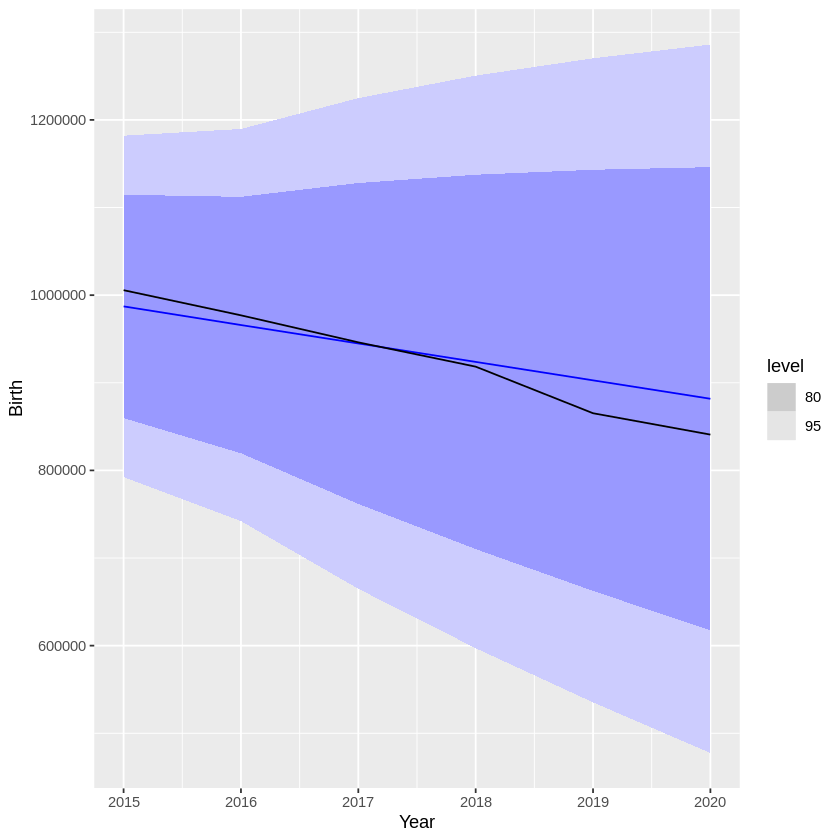

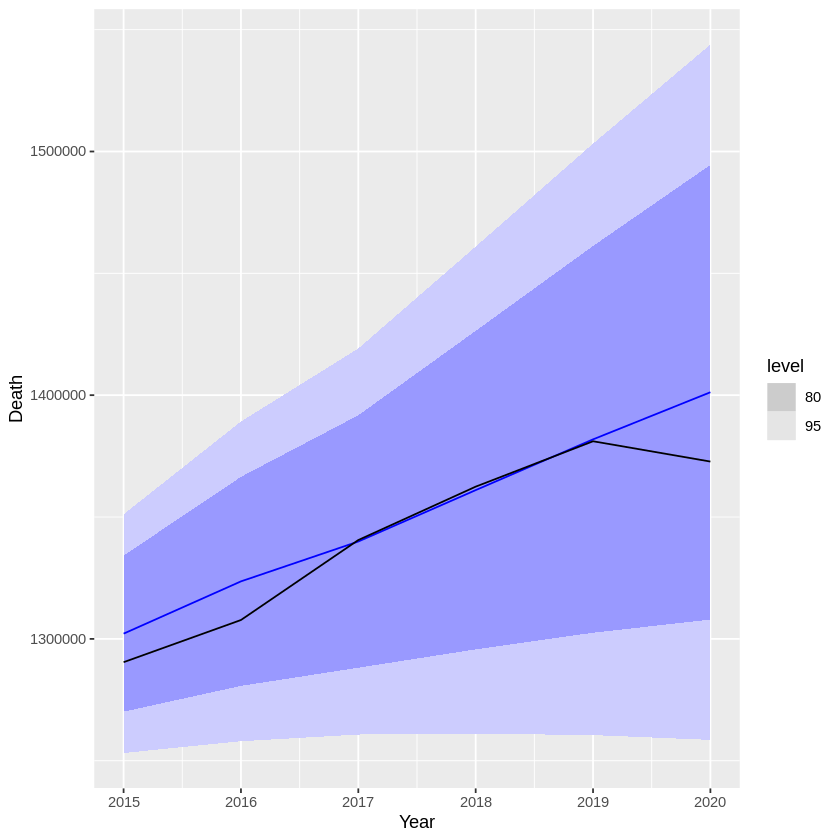

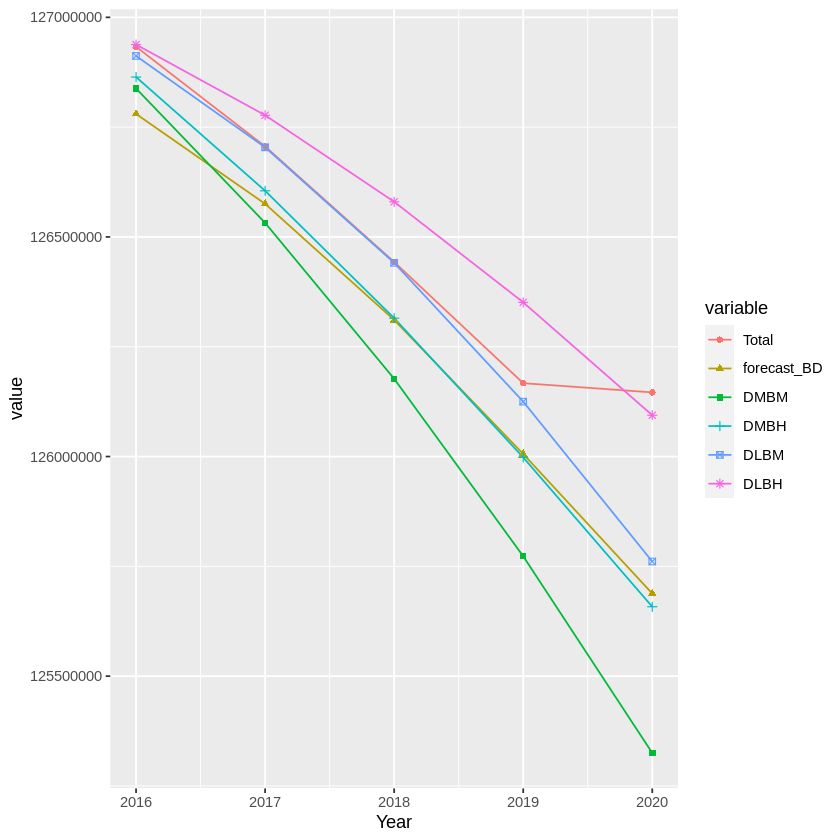

In [21]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/forecast_ipss.csv" )) -> ipssURL

# ネット上のファイル読み込み
ipssURL |>
  read_csv( show_col_types = FALSE ) |>
  # ＴＳＩＢＢＬＥライブラリに変換
  as_tsibble( index = Year ) -> ipss_test

# ＡＲＩＭＡモデル予測をはforecast_BD
# 実データがTotal
# 社人研の結果は、例えば死亡中位出生中位だとDMBM
  pop_arima_f2[ 2:6, 1:2 ] |>
  inner_join( pop_test2, by = "Year") |>
  inner_join( ipss_test, by = "Year") |>
  select( Year,
          Total,
          forecast_BD,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) -> join_test2

join_test2

# ライブラリの読み込み
library( reshape2 )

join_test2 |> 
  melt(id="Year",measure=c( "Total",
                            "forecast_BD",
                            "DMBM",
                            "DMBH",
                            "DLBM",
                            "DLBH")) -> join_plot2

#描画
pop_test2 |>
  select( Year, Birth ) -> pop_testB 
pop_arimaB_f |> autoplot() +
  autolayer( pop_testB )

pop_test2 |>
  select( Year, Death ) -> pop_testD
pop_arimaD_f |> autoplot() +
  autolayer( pop_testD )

ggplot( join_plot2,
        aes(x = Year,
            y = value,
            shape = variable,
            colour = variable,
            group = variable )) +
  geom_line() +
  geom_point()

今度は少し低めに出てしまいました。  
どうやら、死亡数を高めに見積もっている事が原因のようです。

# 次のステップ



*   同じ事をPythonでやってみる。　->　 [ Python_ARIMA_2 ](https://colab.research.google.com/drive/1Hqauyd81PvWexKfJvrkYFm8YTfW4MplS?usp=sharing)

*   色んなモデルを当てはめてみる　->　こちら
*   死亡率を使って推計する　->　[ R_ARIMA_3 ](https://colab.research.google.com/drive/1MZ2XYpcnUZ8Dg7uYU-BEqRQOPy0y7u8r?usp=sharing)

